In [97]:
## importing the necessary files
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.impute import SimpleImputer as imputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import csv

In [98]:
## defining function to load in dataset
def build_dfs(vectorized_train):
    X = pd.read_pickle(vectorized_train)
    X_limited = pd.DataFrame()
    X[pd.isnull(X)] = 0.
    X = X.astype(pd.SparseDtype('float', 0.))
    X['sum_all'] = X['sum_1'] + X['sum_0'] + X['sum_none']
    X['sum_ratio'] = X['sum_1'] / (X['sum_0'] + X['sum_none'] + 1)
    X['sum_diff'] = X['sum_1']-X['sum_0']
    X=X.sparse.to_dense()
    cols = X.columns
    # imputer_ = imputer(missing_values=-1,strategy='mean',add_indicator=False)
    # X = imputer_.fit_transform(X)
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)
    X = X.astype(pd.SparseDtype('float', 0.))
    print(type(X))
    X = pd.DataFrame(X,columns=cols)
    X_limited = pd.DataFrame(X,columns=cols).loc[:,['sum_diff', 'mean_age', 'mean_concreteness', 'mean_freq_pm', 'min_perc_known']]
    X_limited = X_limited.sparse.to_dense()
    X_std = StandardScaler().fit_transform(X_limited)    
    print("Kmeans: Step 1 - file read in", X.shape)
    return X, X_limited, X_std

In [99]:
## running the function to build out datsets
## NOTE - this file needs to replaced with local version
X, X_limited, X_std = build_dfs("data/model/vtF_topickle.pkl")

<class 'pandas.core.frame.DataFrame'>
Kmeans: Step 1 - file read in (416768, 24)


In [100]:
## let's take a look at the features
X_limited

,sum_diff,mean_age,mean_concreteness,mean_freq_pm,min_perc_known
0,117.0,5.923793,2.354815,5364.601724,0.89
1,62.0,7.499286,2.117500,5732.926429,0.93
2,120.0,5.322162,2.357647,6083.834865,0.93
3,109.0,6.738889,2.997143,1700.148519,0.93
4,106.0,5.396667,2.364667,10288.158000,0.90
...,...,...,...,...,...
416763,43.0,5.790000,2.732000,3437.103333,0.93
416764,50.0,6.581875,2.158571,6424.285000,0.93
416765,24.0,6.788889,2.973750,3699.767778,1.00
416766,106.0,4.932222,2.504167,6701.296111,0.93


In [101]:
## loading in a dataset to visualize k-means model performance
## NOTE - this file needs to replaced with local version
df = pd.read_csv("data/model/output.csv")

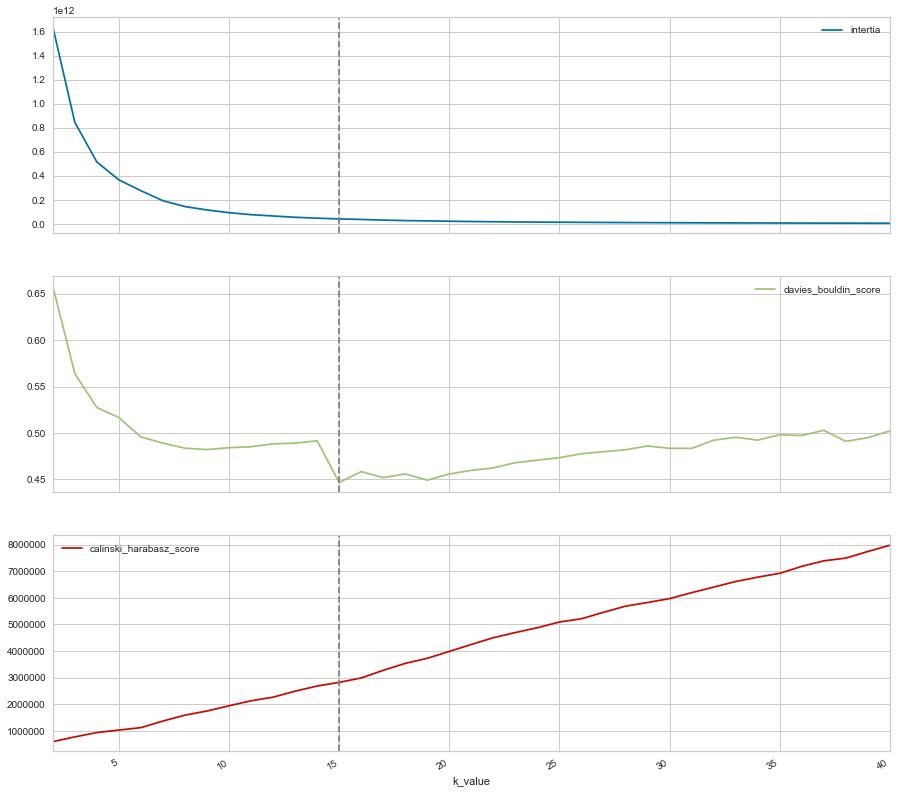

In [102]:
## visualizing the evaluation metrics from the k-means model run
axes = df.plot(subplots=True, 
        layout=(3,1),
        x='k_value', 
        y=['intertia', 'davies_bouldin_score', 'calinski_harabasz_score'], 
        figsize=(15, 15)); 
plt.legend(loc='best')

for c in axes:
    for ax in c:
        ax.axvline(x=15, color='grey',linestyle='--')

([<matplotlib.axis.XTick at 0x7f85de886910>,
 <a list of 2 Text xticklabel objects>)

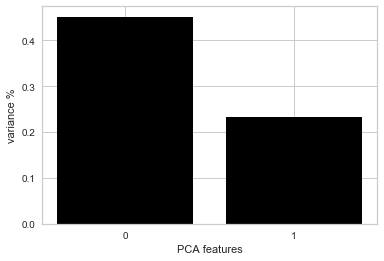

In [103]:
# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [104]:
## Let's run the k-means model for 15 clusters
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=42).fit(X_limited)

In [105]:
## producing a new dataframe with a predicted column
def kmeans_preds(X_limited, kmeans):
    n = 37888  #chunk row size
    list_df = [X_limited[i:i+n] for i in range(0,X_limited.shape[0],n)] #producing chunks
    print(len(list_df),X_limited.shape[0])
    final_predictions = np.array([])
    for i in range(0,11):
        predict=kmeans.predict(list_df[i])
        final_predictions = np.append(final_predictions,predict)
        print("Kmeans: Step 3 - predictions, part", i, "of 10")
    X_limited['unsupervised_learning_clusterID'] = final_predictions.tolist()
    return X_limited

In [106]:
### running the function to produce the new dataframe
X_limited = kmeans_preds(X_limited, kmeans)

11 416768
Kmeans: Step 3 - predictions, part 0 of 10
Kmeans: Step 3 - predictions, part 1 of 10
Kmeans: Step 3 - predictions, part 2 of 10
Kmeans: Step 3 - predictions, part 3 of 10
Kmeans: Step 3 - predictions, part 4 of 10
Kmeans: Step 3 - predictions, part 5 of 10
Kmeans: Step 3 - predictions, part 6 of 10
Kmeans: Step 3 - predictions, part 7 of 10
Kmeans: Step 3 - predictions, part 8 of 10
Kmeans: Step 3 - predictions, part 9 of 10
Kmeans: Step 3 - predictions, part 10 of 10


Text(0.5, 1.0, 'Visualizing clusters with two principal components')

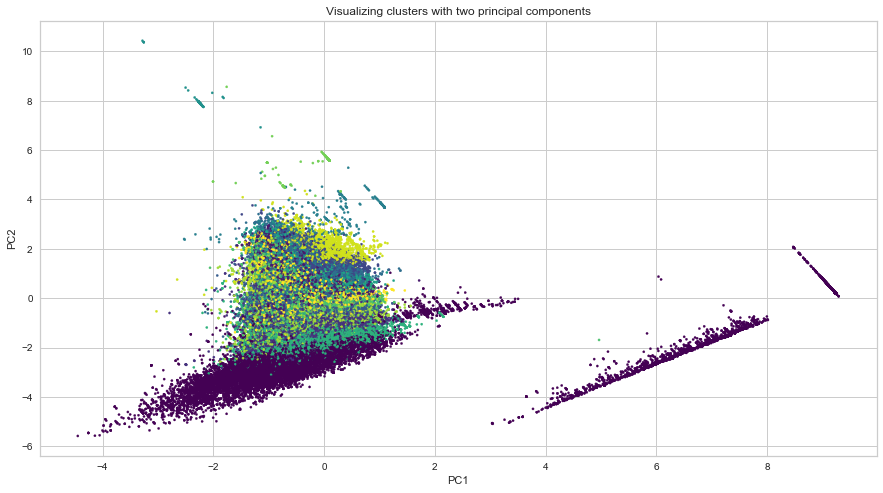

In [107]:
## ploting the two dimensions, and color coding the points based on their k-means predicted cluster
plt.figure(figsize=(15,8))
plt.scatter(x=principalComponents[:,0], 
            y=principalComponents[:,1], 
            c=X_limited['unsupervised_learning_clusterID'].values, 
            s=5, 
            cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualizing clusters with two principal components')